In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r "/content/drive/MyDrive/Metrics Baseline/Data/results_resnet/" ./

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

def set_size(w,h):
  """Set matplot figure size"""
  plt.rcParams["figure.figsize"] = [w,h]

def show(img, **kwargs):
  img = np.array(img)
  img -= img.min()
  img /= img.max()
  plt.imshow(img, **kwargs)
  plt.axis('off')

import seaborn as sns
sns.set(font_scale=2)

<ipython-input-2-255f4ac980e9>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
from matplotlib.colors import ListedColormap
import matplotlib
import colorsys

def get_alpha_cmap(cmap):
  if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)
  else:
    c = np.array((cmap[0]/255.0, cmap[1]/255.0, cmap[2]/255.0))

    cmax = colorsys.rgb_to_hls(*c)
    cmax = np.array(cmax)
    cmax[-1] = 1.0

    cmax = np.clip(np.array(colorsys.hls_to_rgb(*cmax)), 0, 1)
    #cmax = np.clip(c * 1.2, 0, 1)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [c,cmax])

  alpha_cmap = cmap(np.arange(256))
  alpha_cmap[:,-1] = np.linspace(0, 0.85, 256)
  alpha_cmap = ListedColormap(alpha_cmap)

  return alpha_cmap

slack_blue  = get_alpha_cmap((54, 197, 240))
slack_green = get_alpha_cmap((46, 182, 125) )
slack_red   = get_alpha_cmap((210, 40, 95))
slack_yellow = get_alpha_cmap((236, 178, 46))
slack_violet = get_alpha_cmap((84, 25, 85))

google_blue = get_alpha_cmap((66, 133, 244))
google_red = get_alpha_cmap((219, 68, 55))
google_yellow= get_alpha_cmap((244, 180, 0))
google_green = get_alpha_cmap((15, 157, 88))

deep_purple = get_alpha_cmap((103, 58, 183))
pink = get_alpha_cmap((236, 64, 122))
anthracite = get_alpha_cmap((13, 13, 21))

brown = get_alpha_cmap((121, 85, 72))

In [6]:
import os

results = {}

for p in os.listdir("/content/results_resnet"):
  if "ood_" not in p and 'resnet' not in p:
    print(p)
    data = np.load('/content/results_resnet/'+p, allow_pickle=True)[()]
    data = [(m, d, i, u) for m, d, i, u in data if 'Guided' not in m]
    deletions = [(m.replace('resnet50_', '').replace('.npy', ''), d) for m, d, i, _ in data]
    insertions = [(m.replace('resnet50_', '').replace('.npy', ''), i) for m, d, i, _ in data]
    methods = [m.replace('resnet50_', '').replace('.npy', '') for m, d, i, _ in data]
    results[p.replace('.npy', '')] = (deletions, insertions)

baselines = list(results.keys())

mean.npy
uniform.npy
scramble_phase.npy
zero.npy
local_mean.npy
local_permutation.npy
median.npy
random_color.npy
permutation.npy
normal.npy
scramble_amplitude.npy


In [7]:
method_to_id = {m : i for m, i in enumerate(methods)}
method_to_id, baselines

({0: 'Occlusion',
  1: 'SobolAttributionMethod',
  2: 'Saliency',
  3: 'IntegratedGradients',
  4: 'VarGrad',
  5: 'SmoothGrad',
  6: 'SquareGrad',
  7: 'GradCAMPP',
  8: 'DeconvNet',
  9: 'GradCAM',
  10: 'GradientInput',
  11: 'Rise',
  12: 'HsicAttributionMethod'},
 ['mean',
  'uniform',
  'scramble_phase',
  'zero',
  'local_mean',
  'local_permutation',
  'median',
  'random_color',
  'permutation',
  'normal',
  'scramble_amplitude'])

In [8]:
method_to_id = {m : i for m, i in enumerate(methods)}
method_to_id = {m : i for m, i in enumerate(methods)}

ranks_del = {m: {} for m in methods}
ranks_ins = {m: {} for m in methods}

for baseline in results.keys():
  deletions, insertions = results[baseline]

  order_del = np.argsort([float(d) for m, d in deletions])
  order_ins = np.argsort([float(i) for m, i in insertions])[::-1]

  for rank_i, i in enumerate(order_del):
    ranks_del[deletions[i][0]][baseline] = rank_i

  for rank_i, i in enumerate(order_ins):
    ranks_ins[insertions[i][0]][baseline] = rank_i

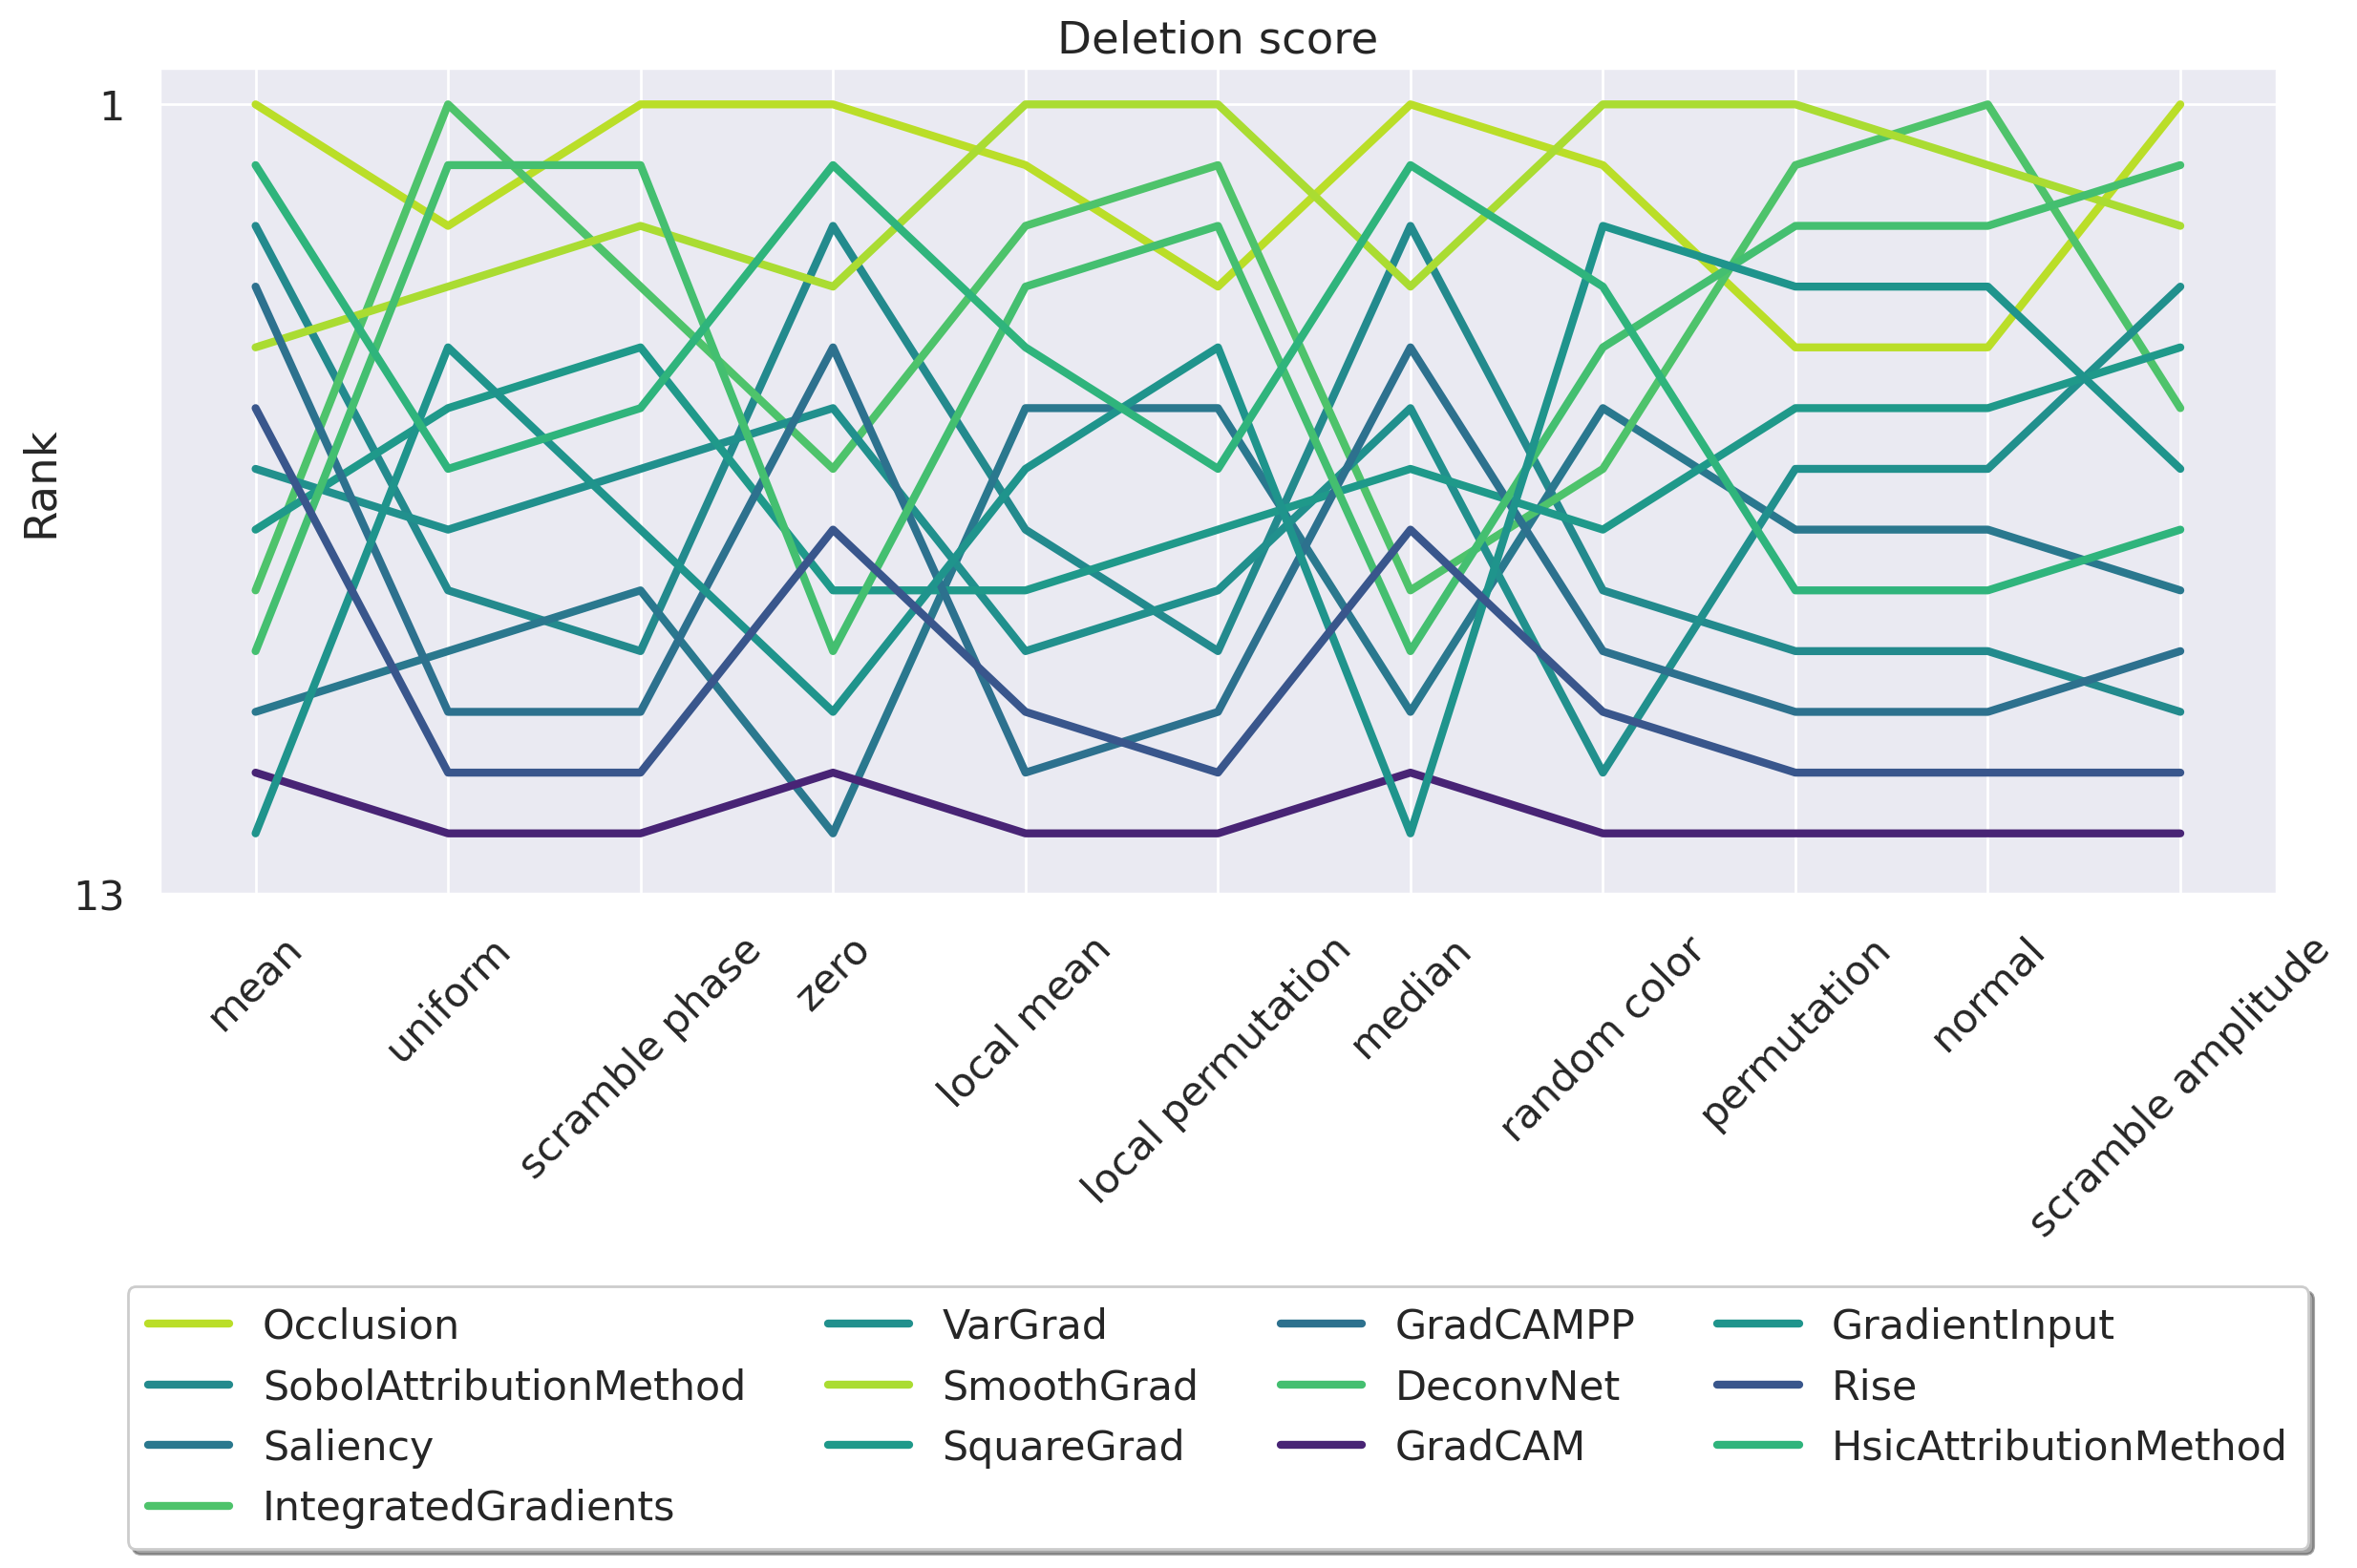

In [16]:
sns.set(font_scale=1.4)
set_size(13, 10)
cmap = plt.get_cmap('viridis_r')

lw = 3.0

for m in methods:
  order = [len(methods) - ranks_del[m][b] for b in baselines]
  color = cmap((len(methods) - np.mean(order)) / len(methods))
  plt.plot(order, label=m, c=color, linewidth=lw)

legend   = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.45),
                      fancybox=True, shadow=True, borderpad=0.5, ncol=4, frameon=True,
                      facecolor='white')

plt.xticks(range(len(baselines)), [b.replace('_', ' ') for b in baselines], rotation=45)
#plt.yticks(range(1, len(methods)+1), [len(methods) - i for i in range(len(methods))])
plt.yticks([0, len(methods)], [len(methods), 1])
plt.ylabel('Rank')
#plt.xlabel('Baselines')
plt.title("Deletion score")
plt.tight_layout()
plt.savefig('deletion_ranking.png', dpi=400, transparent=True)
plt.show()

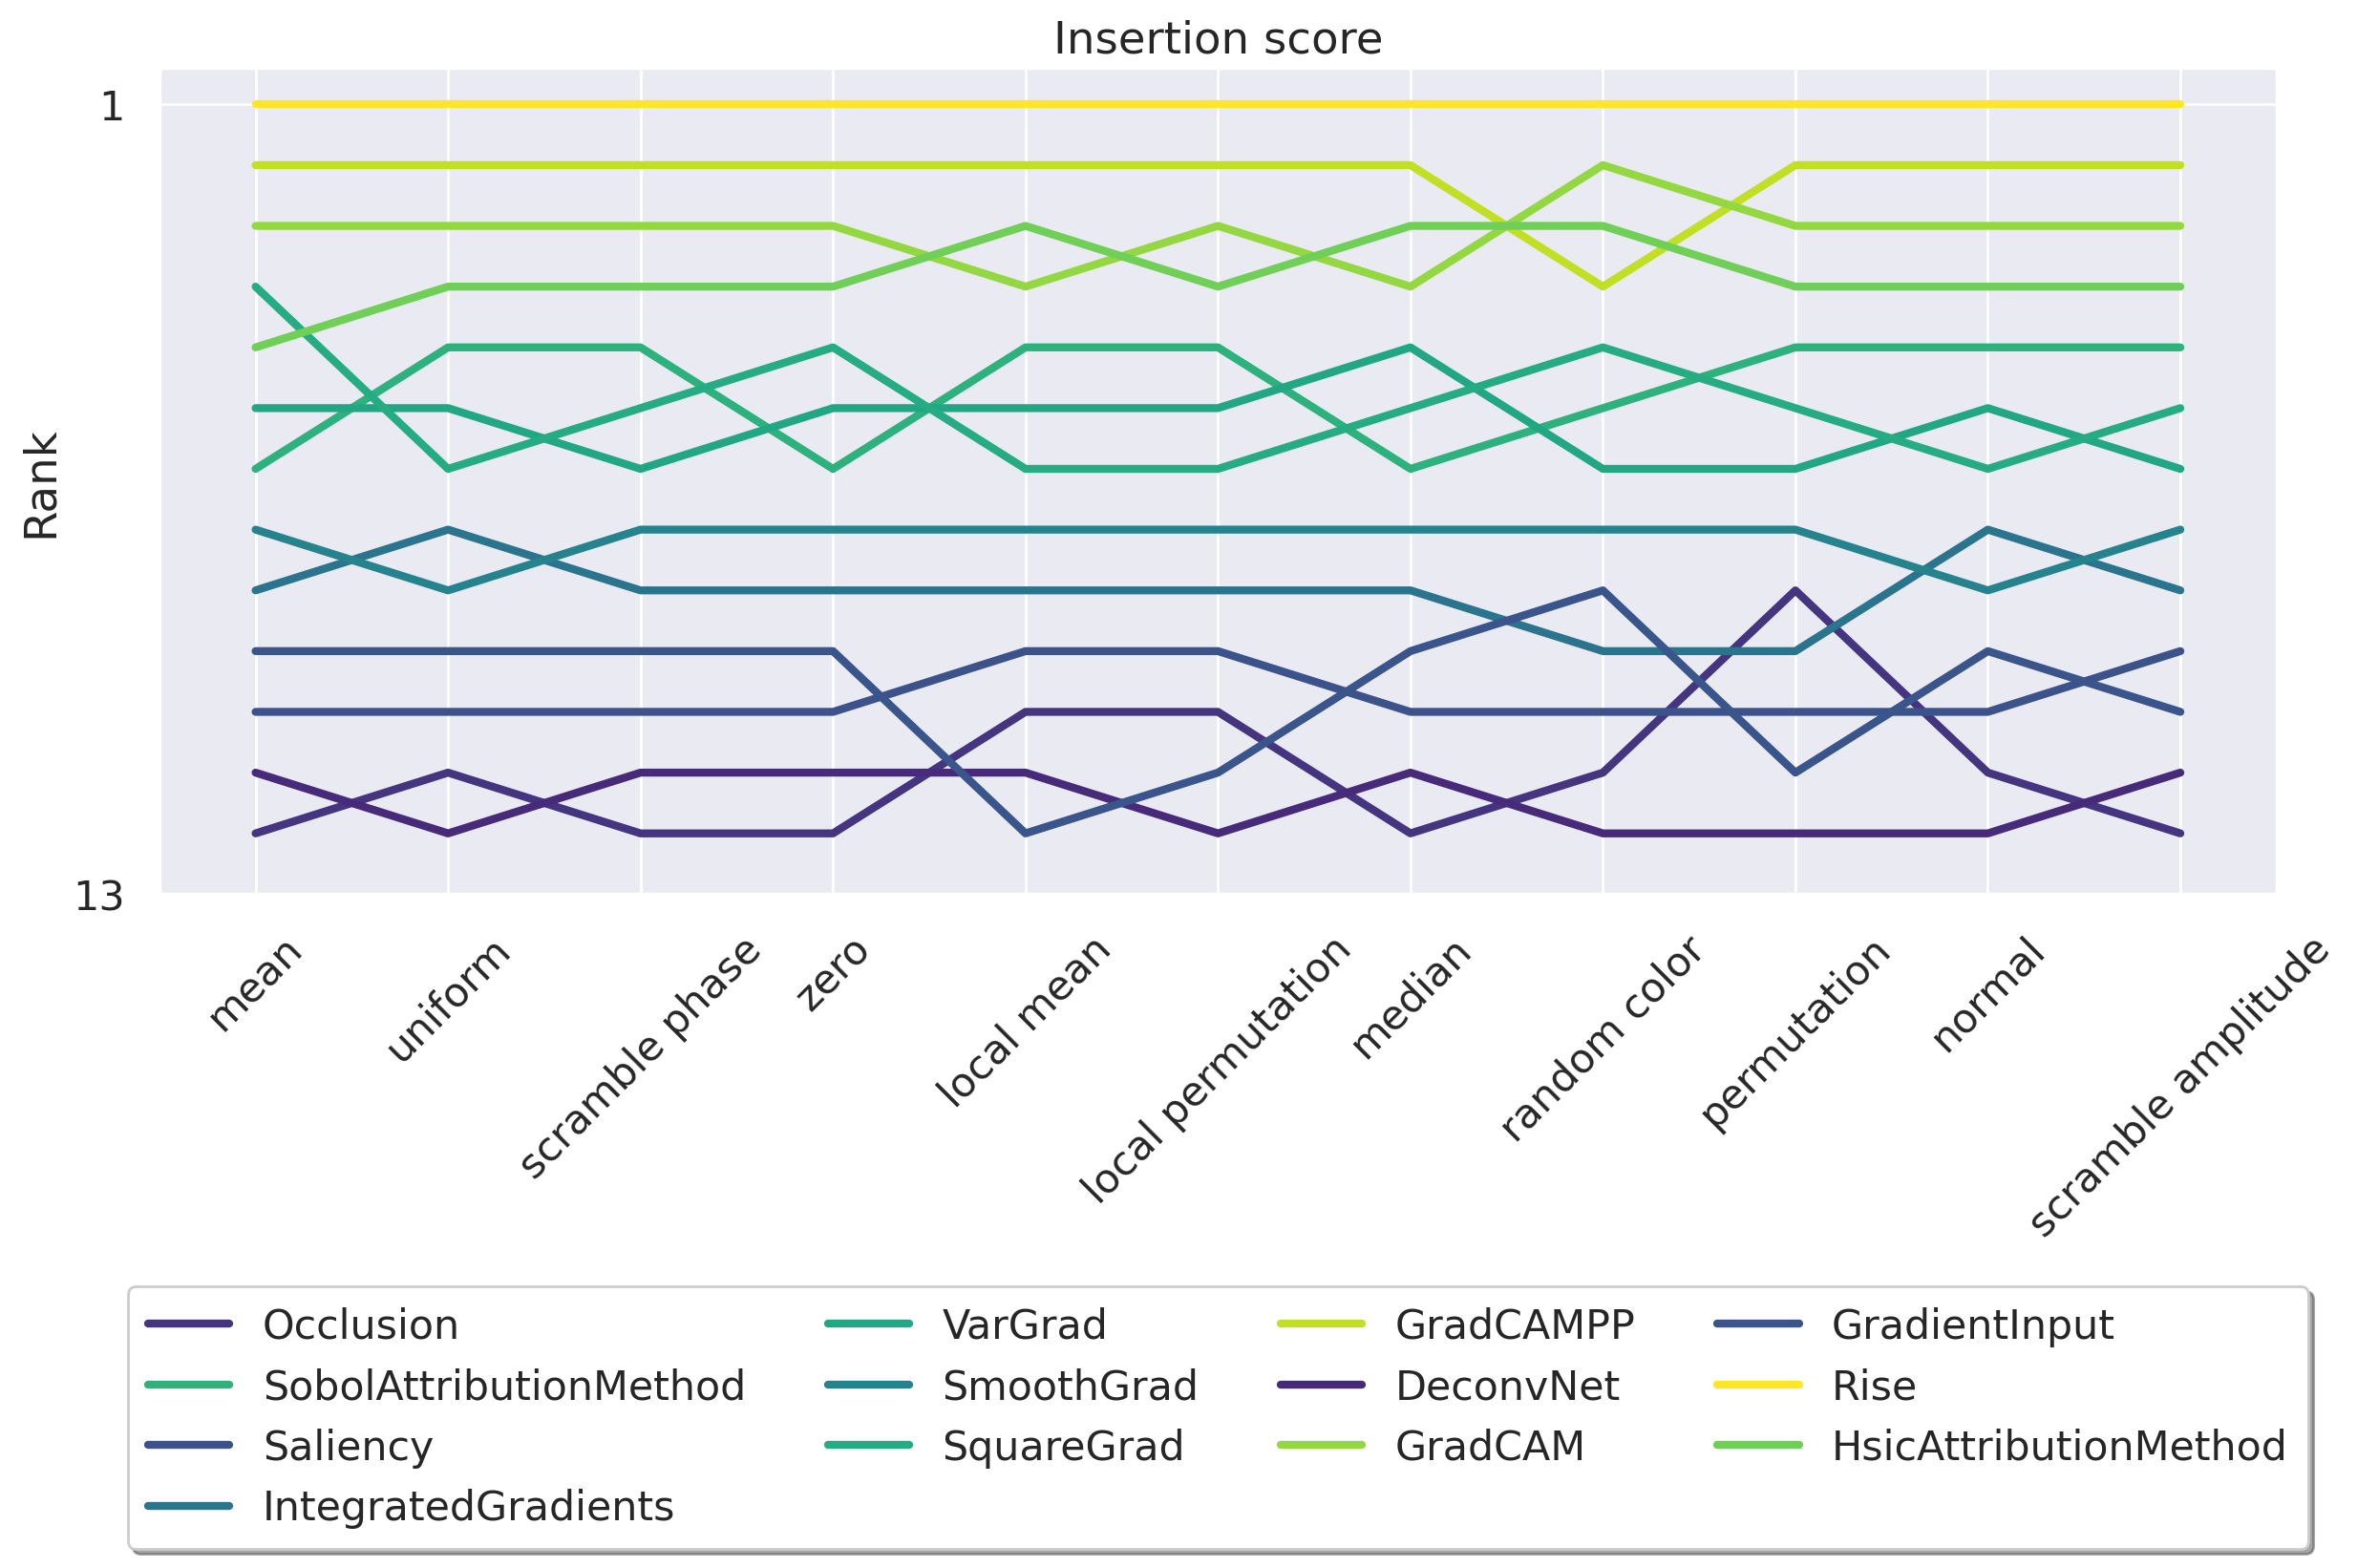

In [19]:
sns.set(font_scale=1.4)
set_size(13, 10)
cmap = plt.get_cmap('viridis_r')

lw = 3.0

for m in methods:
  order = [len(methods) - ranks_ins[m][b] for b in baselines]
  color = cmap((len(methods) - np.mean(order)) / len(methods))
  plt.plot(order, label=m, c=color, linewidth=lw)

legend   = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.45),
                      fancybox=True, shadow=True, borderpad=0.5, ncol=4, frameon=True,
                      facecolor='white')

plt.xticks(range(len(baselines)), [b.replace('_', ' ') for b in baselines], rotation=45)
#plt.yticks(range(1, len(methods)+1), [len(methods) - i for i in range(len(methods))])
plt.yticks([0, len(methods)], [len(methods), 1])
plt.ylabel('Rank')
#plt.xlabel('Baselines')
plt.title("Insertion score")
plt.tight_layout()
plt.savefig('insertion_ranking.png', dpi=400, transparent=True)
plt.show()

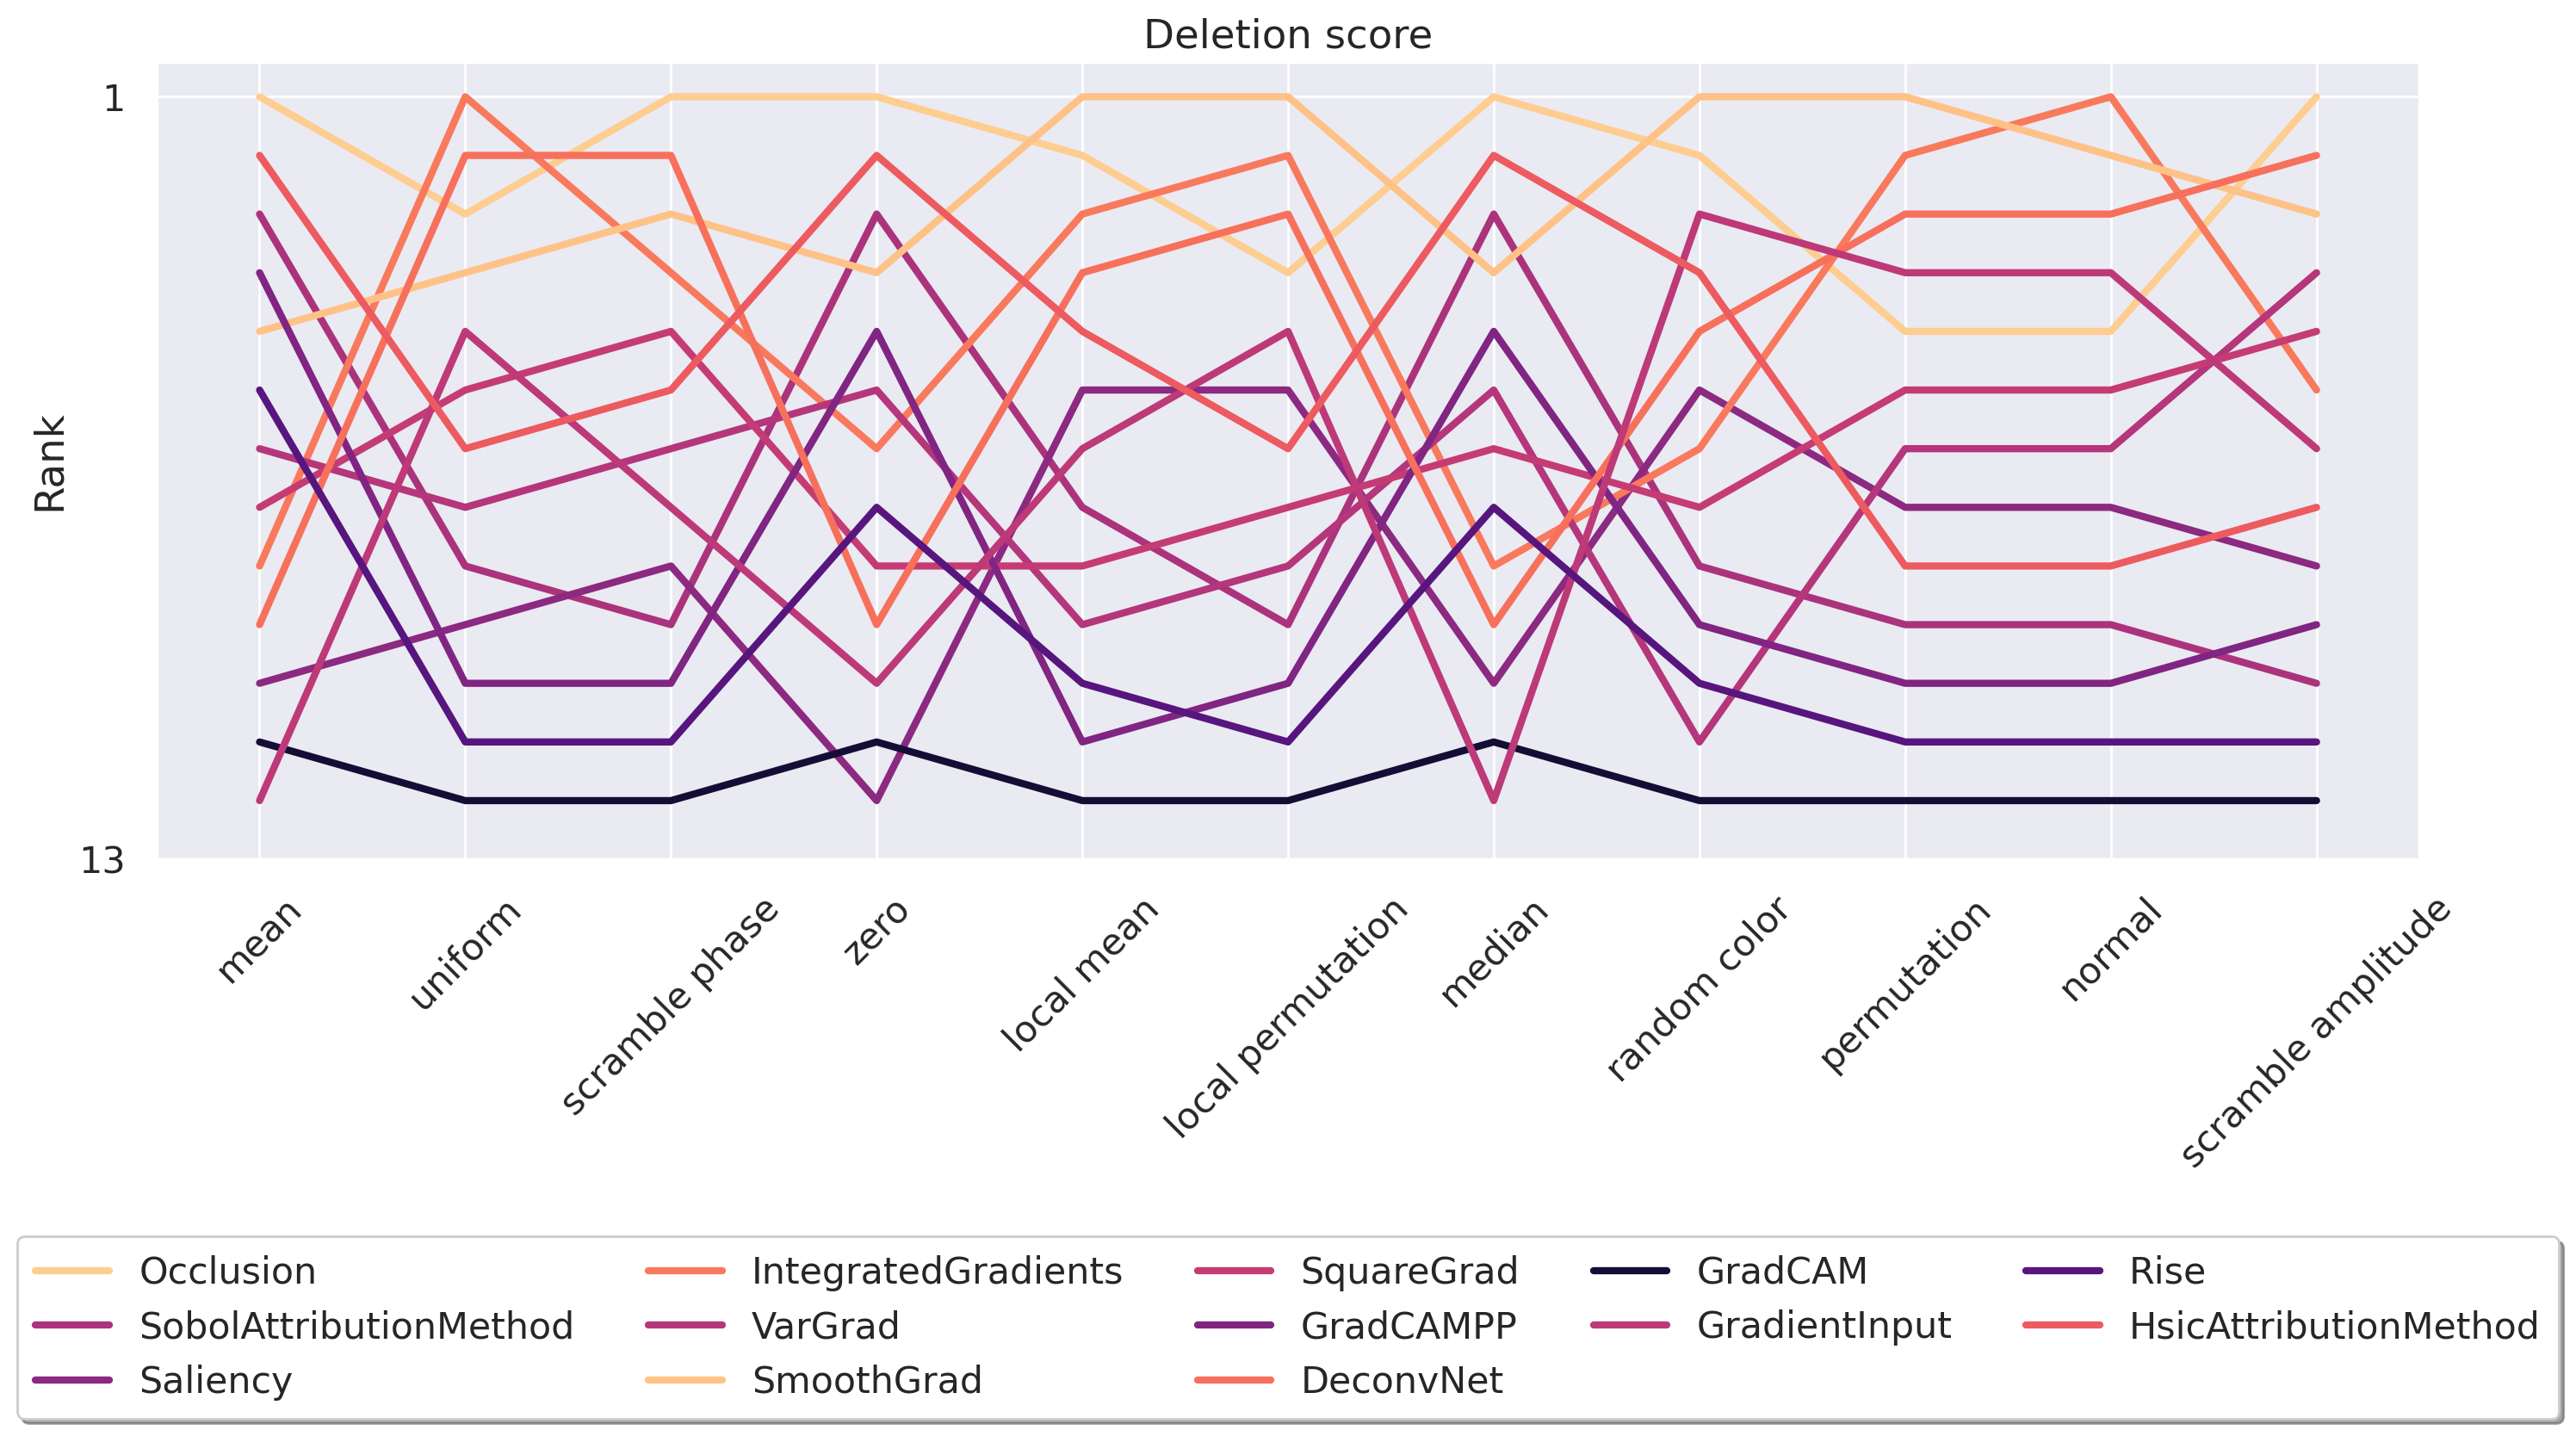

In [13]:
sns.set(font_scale=1.4)
set_size(16, 10)
cmap = plt.get_cmap('magma_r')

lw = 3.0

for m in methods:
  order = [len(methods) - ranks_del[m][b] for b in baselines]
  color = cmap((len(methods) - np.mean(order)) / len(methods))
  plt.plot(order, label=m, c=color, linewidth=lw)

legend   = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.45),
                      fancybox=True, shadow=True, borderpad=0.5, ncol=5, frameon=True,
                      facecolor='white')

plt.xticks(range(len(baselines)), [b.replace('_', ' ') for b in baselines], rotation=45)
#plt.yticks(range(1, len(methods)+1), [len(methods) - i for i in range(len(methods))])
plt.yticks([0, len(methods)], [len(methods), 1])
plt.ylabel('Rank')
#plt.xlabel('Baselines')
plt.title("Deletion score")
plt.tight_layout()
plt.savefig('deletion_ranking.png', dpi=400, transparent=True)
plt.show()

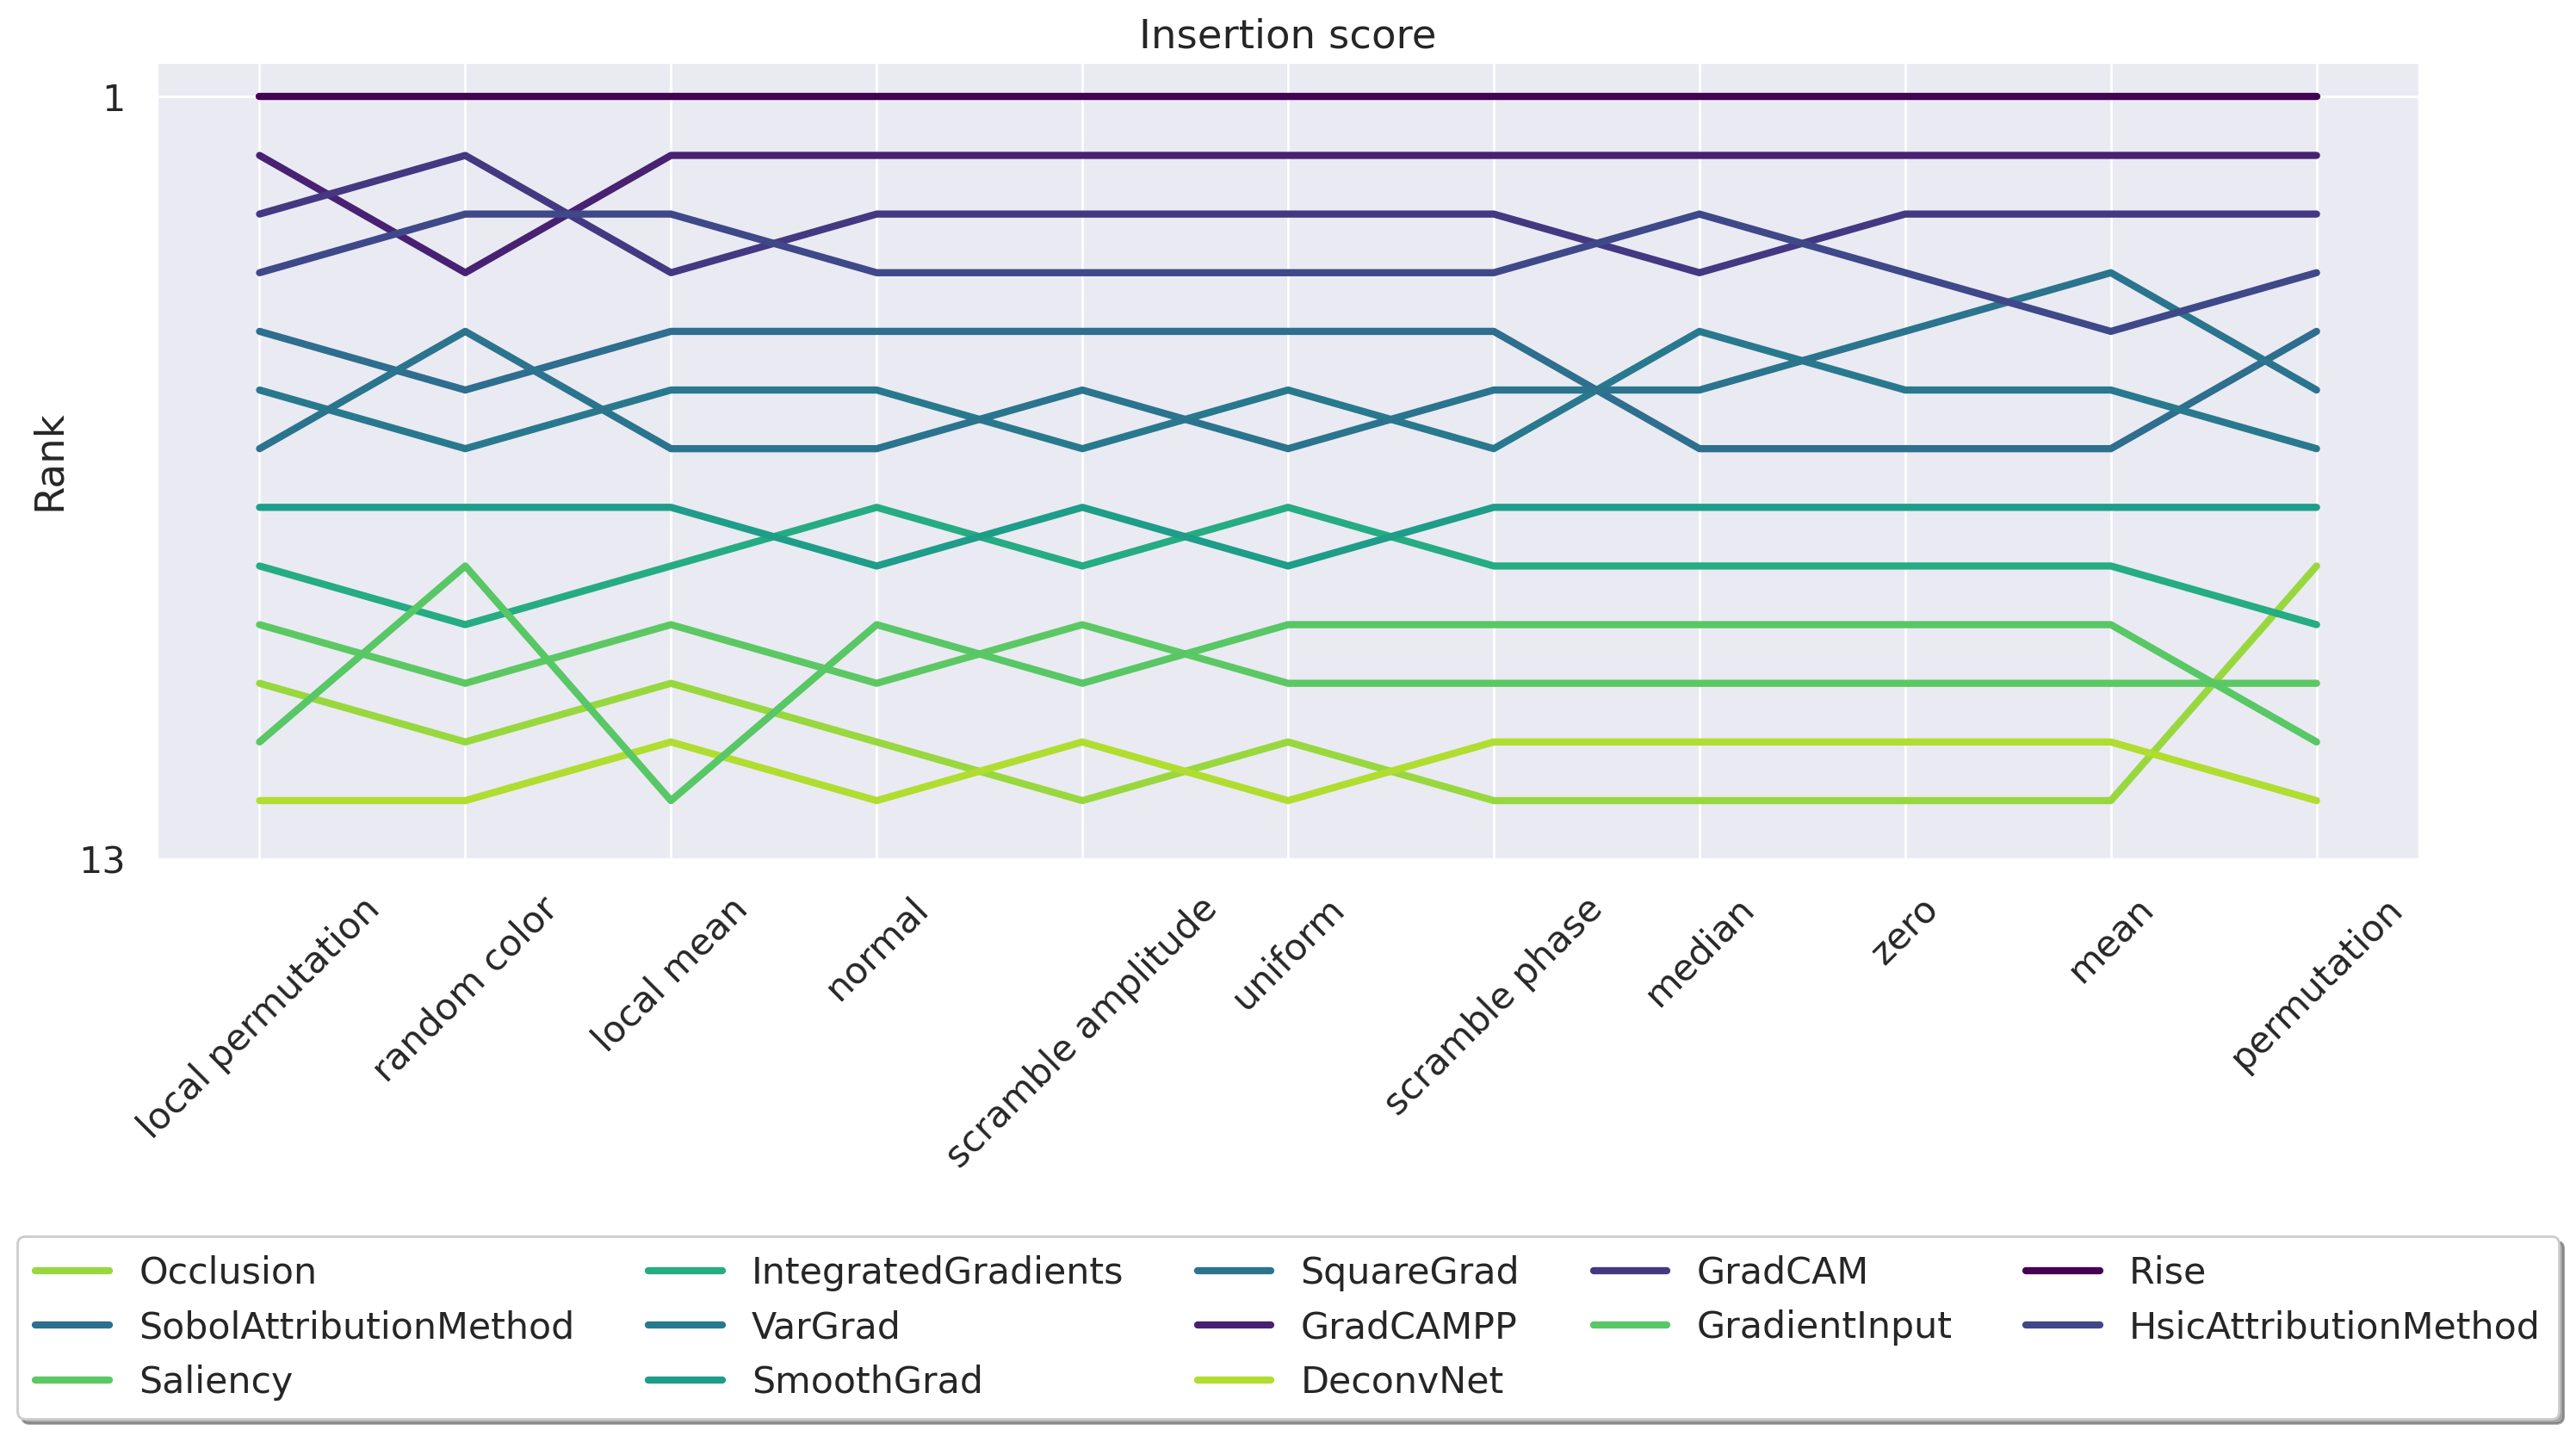

In [ ]:
sns.set(font_scale=1.4)
set_size(16, 10)
cmap = plt.get_cmap('viridis')

lw = 3.0

for m in methods:
  order = [len(methods) - ranks_ins[m][b] for b in baselines]
  color = cmap((len(methods) - np.mean(order)) / len(methods))
  plt.plot(order, label=m, c=color, linewidth=lw)

legend   = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.45),
                      fancybox=True, shadow=True, borderpad=0.5, ncol=5, frameon=True,
                      facecolor='white') # = ivan

plt.xticks(range(len(baselines)), [b.replace('_', ' ') for b in baselines], rotation=45)
#plt.yticks(range(1, len(methods)+1), [len(methods) - i for i in range(len(methods))])
plt.yticks([0, len(methods)], [len(methods), 1])
plt.ylabel('Rank')
#plt.xlabel('Baselines')
plt.title("Insertion score")
plt.tight_layout()
plt.savefig('insertion_ranking.png', dpi=400, transparent=True)
plt.show()

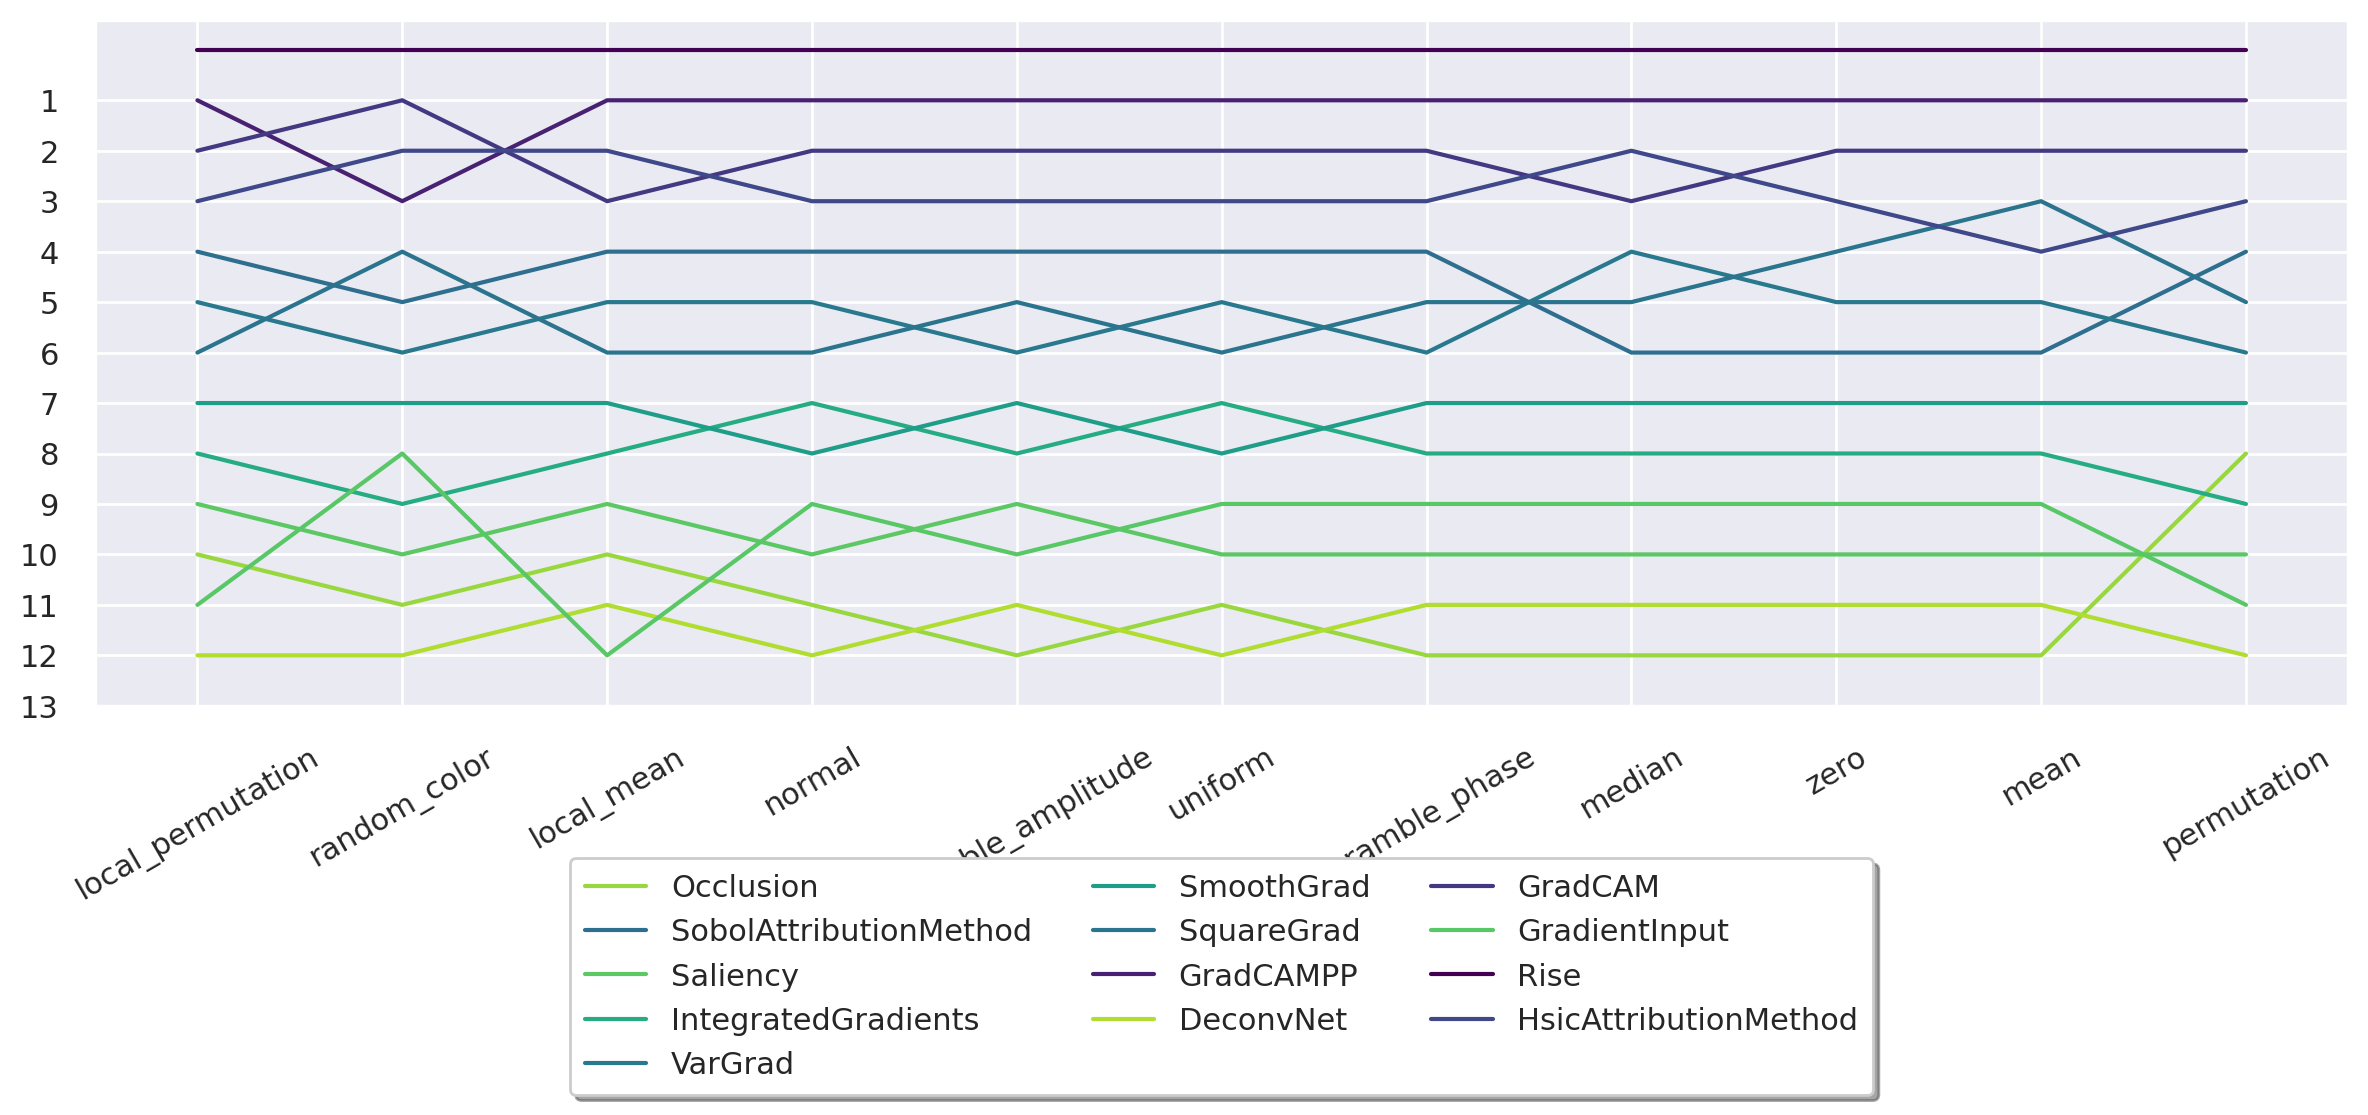

In [ ]:
sns.set(font_scale=1)
set_size(12, 6)
cmap = plt.get_cmap('viridis')


for m in methods:
  order = [len(methods) - ranks_ins[m][b] for b in baselines]
  color = cmap((len(methods) - np.mean(order)) / len(methods))
  plt.plot(order, label=m, c=color)

legend   = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2),
                      fancybox=True, shadow=True, borderpad=0.5, ncol=3, frameon=True,
                      facecolor='white') # = ivan

plt.tight_layout()
plt.xticks(range(len(baselines)), baselines, rotation=30)
plt.yticks(range(len(methods)), [len(methods) - i for i in range(len(methods))])
plt.show()